# Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
import os
import itertools
from pyfuncs import *

import time as st

startdir = '/Users/leo/Desktop/ResearchPhD/PitchControl/analysis/'
%qtconsole

# Read in selected data, combine into one large dataframe

In [2]:
# runDates = ['20210803_1','20210816','20210816_1','20210817_1','20210818_1']
runDates = ['20210803_1','20210816_1','20210817_1','20210818_1','20210819']

# Load dataframes
os.chdir(os.path.join(startdir,'preprocessedCache'))
for i,d in enumerate(runDates):
    dtemp = pd.read_hdf(d+'.h5')
    dtemp['date'] =  d
    if i==0:
        df = dtemp
    else:
        df = df.append(dtemp)
# Load other relevant variables
translations = []
for d in runDates:
    translations.append(pickleRead(os.path.join(startdir, 'preprocessedCache', 'vars')+'_'+d+'.pkl'))
# Important information that I'll just hard-code in
channelsEMG = ['LDVM', 'LDLM', 'RDLM', 'RDVM']
channelsFT = ['fx', 'fy', 'fz', 'mx', 'my', 'mz']
fsamp = 10000
# Recreate first spike columns because I don't trust them
for m in channelsEMG:
    df[m+'_fs'] = 0
    df[m+'_fs'] = df.groupby(['date','pulse','wb'], group_keys=False).apply(
        lambda g: g[m+'_fs'] + (g[m+'_st'].idxmax() - g[m+'_st'].idxmin()))
# Create first spike columns defined by phase
for m in channelsEMG:
    df[m+'_fsphase'] = 0
    df[m+'_fsphase'] = df.groupby(['date','pulse','wb'], group_keys=False).apply(
        lambda g: g[m+'_fsphase'] + g[m+'_fs'].iloc[0]/len(g))
    # for name, g in df.groupby(['date','pulse','wb']):
    #     df.loc[(df.date==name[0]) & (df.pulse==name[1]) & (df.wb==name[2]),m+'_fsphase'] = g[m+'_fs'].iloc[0]/len(g)
# Define tDVM-tDLM columns
df['tdl'] = (df['LDVM_fs']-df['LDLM_fs'])/10
df['tdr'] = (df['RDVM_fs']-df['RDLM_fs'])/10
df.loc[(df['tdl']<0), 'tdl'] = np.nan
df.loc[(df['tdr']<0), 'tdr'] = np.nan

# 20210816_1 has periods where fz frequency is double spike frequency: Remove these
if '20210816_1' in runDates:
    # determine offending pulses
    issue = df.loc[(df.date=='20210816_1') &
                   (df.wbstate=='pre') &
                   (df.LDLM_st | df.RDLM_st) &
                   (df.phase<0.2)]
    droppulse = np.unique(issue.pulse)
    # Drop them
    df = df.loc[~((df.date=='20210816_1') & (df.pulse.isin(droppulse)))]

# Label pulses where first DLM pulses were due to stim (on spikephase vs stimphase diagonal)
def diagFunc(g):
    tmp = g.loc[g.wb==0,['LDLM_fsphase','RDLM_fsphase','stimphase']].iloc[0]
    returnval = True if (tmp['LDLM_fsphase']>tmp['stimphase']) and (tmp['RDLM_fsphase']>tmp['stimphase']) else False
    return g['stimfirst'] + returnval
df['stimfirst'] = False
df['stimfirst'] = df.groupby(['date','pulse'], group_keys=False).apply(diagFunc)

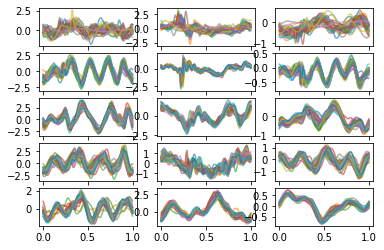

In [3]:
# Quick test plot
fig, ax = plt.subplots(len(runDates), 3, sharex=True)
for i,d in enumerate(runDates):
    dt = df.loc[df.date==d].copy()
    dt = dt.loc[dt.pulse==dt.pulse.iloc[0]]
    for j,m in enumerate(channelsFT[3:]):
        for jj in np.unique(dt['wb']):
            ax[i,j].plot(dt.loc[dt['wb']==jj, 'phase'], dt.loc[dt['wb']==jj, m], alpha=0.6)

# Small plots for introducing data

In [41]:
dt = df.loc[(df.date=='20210818_1') & (df.pulse==30) & (df.wb>-5) & (df.wb<5)]
mcols = ['#559EE0','#E06767','#B13028','#203864']
plt.figure()
for j in np.unique(dt['wb']):
    if j % 2 == 0:
        wbtime = dt.loc[dt['wb']==j, 'Time'].to_numpy()
        plt.axvspan(wbtime[0], wbtime[-1], lw=0, color='#C2C2C2')
for i,m in enumerate(channelsEMG):
    plt.plot(dt.Time, 1.5*i + dt[m], color=mcols[i])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_ticks([])

[]

In [62]:
fig, ax = plt.subplots(2,len(runDates), sharex=True, figsize=(15,5))
for i,d in enumerate(runDates):
    dt = df.loc[(df.stimfirst) & (df.wb!=0) & (df.date==d)]
    
    ax[0,i].hist(dt.loc[dt['LDVM_st'], 'phase'], bins=40, color='b', alpha=0.5, density=True)
    ax[0,i].hist(dt.loc[dt['RDVM_st'], 'phase'], bins=40, color='r', alpha=0.5, density=True)
    ax[1,i].hist(dt.loc[dt['LDLM_st'], 'phase'], bins=40, color='b', alpha=0.5, density=True)
    ax[1,i].hist(dt.loc[dt['RDLM_st'], 'phase'], bins=40, color='r', alpha=0.5, density=True)
    
    ax[0,i].set_title(d)
ax[0,0].set_ylabel('DVM')
ax[1,0].set_ylabel('DLM')
fig.text(0.06, 0.5, 'Density', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'Spike Phase', ha='center')

Text(0.5, 0.04, 'Spike Phase')

# Torques in quiescent moth trials used to make COM translations
Works as a check to indicate that COM has been found: All torques plotted should be minimized to center around 0

[array([11.34315774, -1.99116011, 55.0768696 ]),
 array([ 7.75505109, -5.84197762, 56.33163769]),
 array([ 8.18208076, -1.39892207, 55.71024836]),
 array([12.81044166, -2.61514537, 53.96501382]),
 array([ 4.19873859, -5.09204478, 57.27320637])]

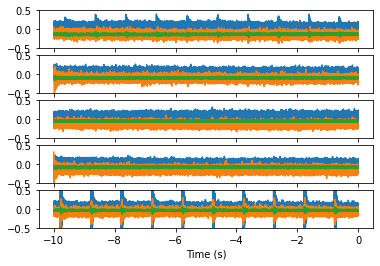

In [3]:
readFrom = 'dropbox'
fig, ax = plt.subplots(len(runDates), 1, sharex=True, sharey=True)
for ii,date in enumerate(runDates):
    # Read empty FT for bias
    biasmat, _, fsamp = readRaw(date, 'empty', doFT=True, readFrom=readFrom)
    bias = biasmat.mean(axis=0)[1:-1]
    # Use quiescent moth from stim characterization to find translation to COM
    charTrials = whichTrials(date, purpose='char', readFrom=readFrom)
    M, _, _ = readRaw(date, str(charTrials[0]).zfill(3), doFT=True, readFrom=readFrom)
    mat = M.mean(axis=0)[1:-1]
    # Apply calibration matrix and bias, get mean forces and torques for quiescent moth
    meanFT = transformFTdata((mat-bias).transpose(), M_trans=np.identity(6))
    lx,ly,lz = translations[runDates.index(date)].x
    lz = lz+20
    M_trans = np.array([
        [1,0,0,0,0,0],
        [0,1,0,0,0,0],
        [0,0,1,0,0,0],
        [0, lz, -ly, 1, 0, 0],
        [-lz, 0, lx, 0, 1, 0],
        [ly, -lx, 0, 0, 0, 1]
        ])
    new = transformFTdata((M[:,1:7]-bias).transpose(), M_trans=M_trans)
    for i in range(3):
        ax[ii].plot(M[:,0], new[:,3+i])
ax[len(runDates)-1].set_xlabel('Time (s)')
ax[0].set_ylim((-0.5,0.5))
[translations[i].x for i in range(len(runDates))]

# Stimulus phase vs spike times

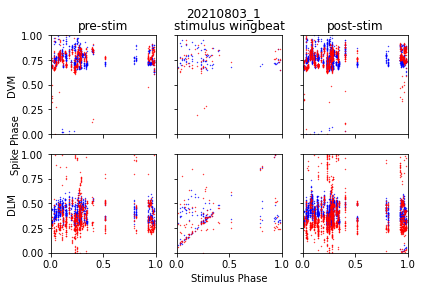

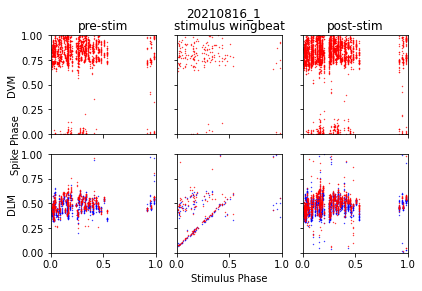

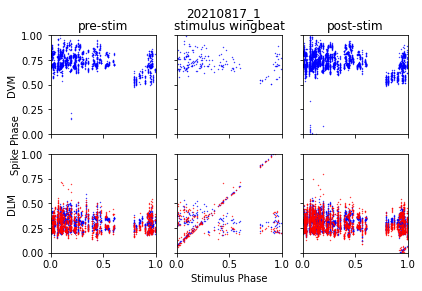

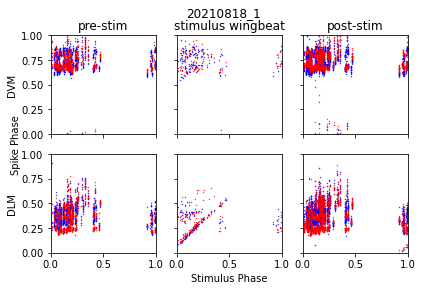

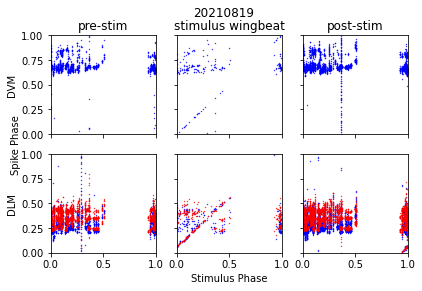

In [5]:
ms = 0.75
axnumbering = {'pre':0,'stim':1,'post':2}
for di,d in enumerate(runDates):
    # fig, ax = plt.subplots(2, 3, figsize=(10,5), sharex=True, sharey=True)
    fig, ax = plt.subplots(2, 3, figsize=(6.4,4), sharex=True, sharey=True)
    for name, g in df.loc[(df.date==d) & (df['LDVM_st'] | df['LDLM_st'] | df['RDLM_st'] | df['RDVM_st'])].groupby('wbstate'):
        i = axnumbering[name]
        # DVM subplot
        ax[0,i].plot(g.loc[g['LDVM_st'],'stimphase'], g.loc[g['LDVM_st'],'phase'], '.', color='blue', markersize=ms)
        ax[0,i].plot(g.loc[g['RDVM_st'],'stimphase'], g.loc[g['RDVM_st'],'phase'], '.', color='red', markersize=ms)
        # DLM subplot
        ax[1,i].plot(g.loc[g['LDLM_st'],'stimphase'], g.loc[g['LDLM_st'],'phase'], '.', color='blue', markersize=ms)
        ax[1,i].plot(g.loc[g['RDLM_st'],'stimphase'], g.loc[g['RDLM_st'],'phase'], '.', color='red', markersize=ms)
    for i,j in itertools.product(range(ax.shape[0]), range(ax.shape[1])):
        ax[i,j].set_xlim((0,1))
        ax[i,j].set_ylim((0,1))
    fig.suptitle(d)
    ax[0,0].set_ylabel('DVM')
    ax[1,0].set_ylabel('DLM')
    fig.text(0.04, 0.5, 'Spike Phase', va='center', rotation='vertical')
    ax[1,1].set_xlabel('Stimulus Phase')
    ax[0,0].set_title('pre-stim')
    ax[0,1].set_title('stimulus wingbeat')
    ax[0,2].set_title('post-stim')


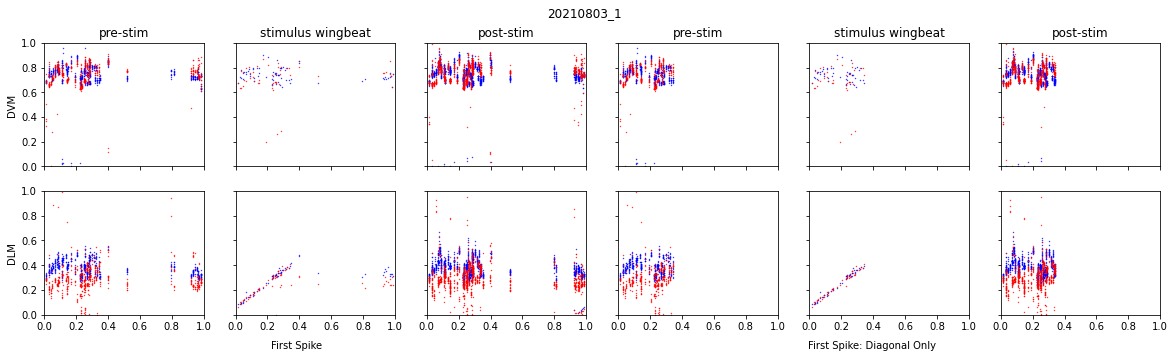

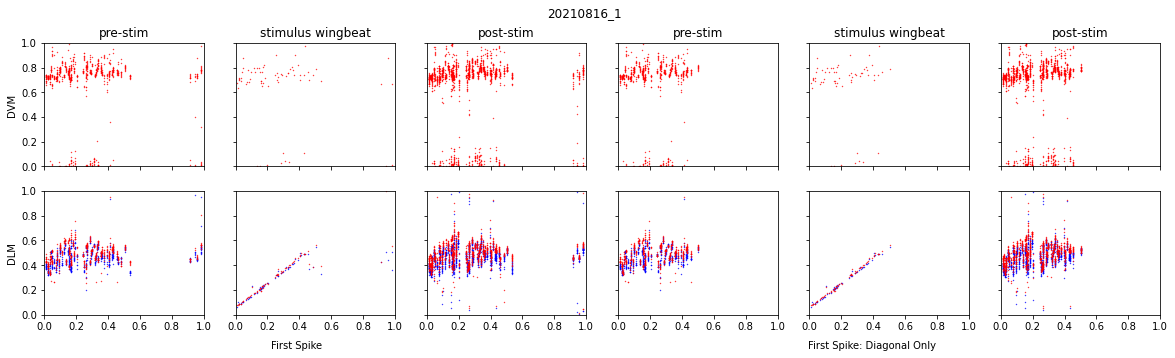

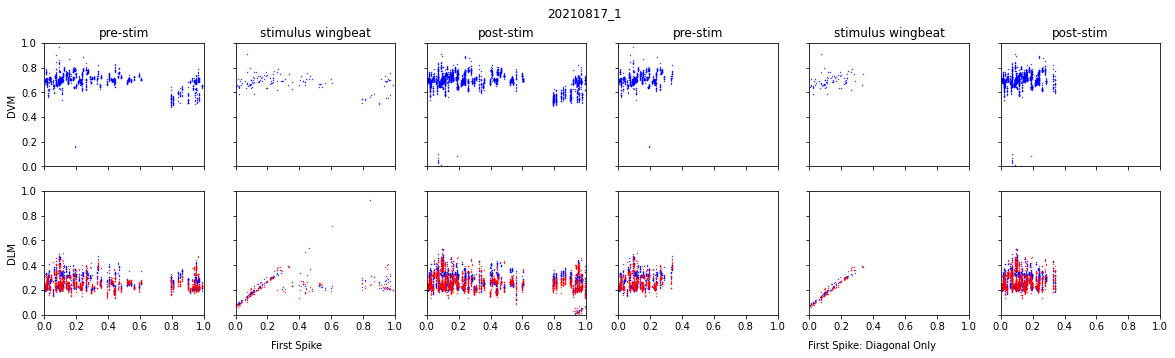

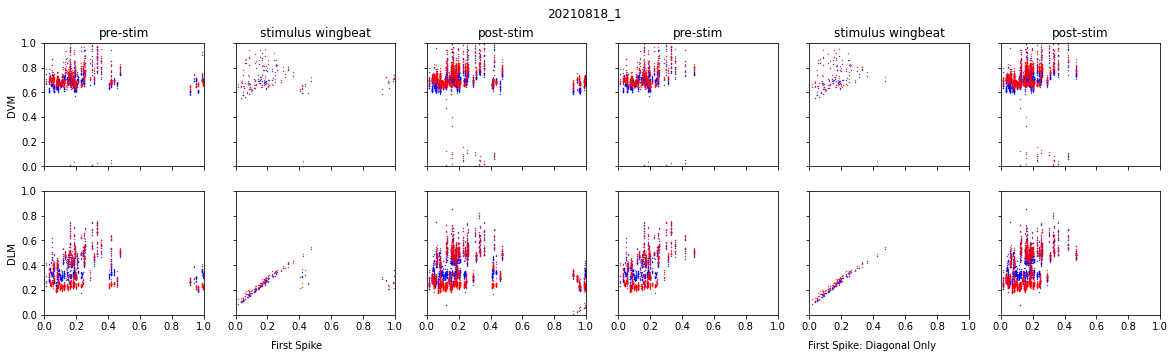

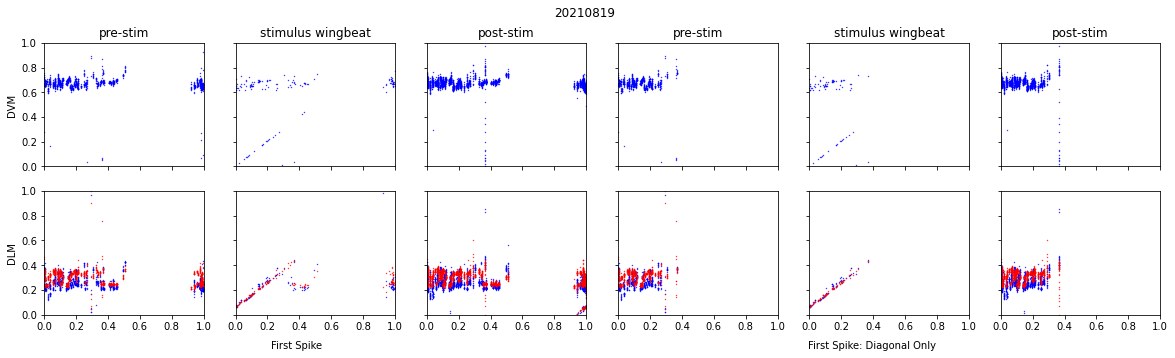

In [6]:
ms = 0.75
axnumbering = {'pre':0,'stim':1,'post':2}
for di,d in enumerate(runDates):
    fig, ax = plt.subplots(2, 6, figsize=(20,5), sharex=True, sharey=True)
    for name, g in df.loc[df.date==d].groupby('wbstate'):
        dt = g.groupby(['pulse','wb']).aggregate('first')
        j = axnumbering[name]
        for m in channelsEMG:
            i = 0 if 'V' in m else 1
            col = 'blue' if m[0]=='L' else 'red'
            ax[i,j].plot(dt.loc[dt[m+'_fs']!=0,'stimphase'], dt.loc[dt[m+'_fsphase']!=0,m+'_fsphase'],
                         '.', color=col, markersize=ms)
        dt = dt.loc[dt.stimfirst]
        for m in channelsEMG:
            i = 0 if 'V' in m else 1
            col = 'blue' if m[0]=='L' else 'red'
            ax[i,j+3].plot(dt.loc[dt[m+'_fs']!=0,'stimphase'], dt.loc[dt[m+'_fsphase']!=0,m+'_fsphase'],
                         '.', color=col, markersize=ms)
    for i,j in itertools.product(range(ax.shape[0]), range(ax.shape[1])):
        ax[i,j].set_xlim((0,1))
        ax[i,j].set_ylim((0,1))
    fig.suptitle(d)
    ax[0,0].set_ylabel('DVM')
    ax[1,0].set_ylabel('DLM')
    fig.text(0.30, 0.03, 'First Spike', ha='center')
    fig.text(0.7, 0.03, 'First Spike: Diagonal Only', ha='center')
    ax[0,0].set_title('pre-stim')
    ax[0,1].set_title('stimulus wingbeat')
    ax[0,2].set_title('post-stim')
    ax[0,3].set_title('pre-stim')
    ax[0,4].set_title('stimulus wingbeat')
    ax[0,5].set_title('post-stim')


# Wingbeat Means

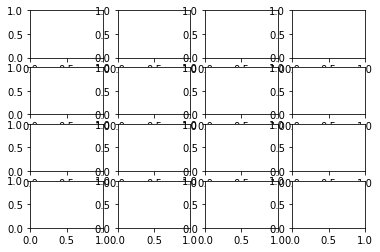

In [97]:
usewb = (-2,2)

# make dataframe subset
dt = df.loc[(df.date!='20210816') & 
            (df.wb>=usewb[0]) & 
            (df.wb<usewb[1]) & 
            (df.stimfirst)].copy()
# Zero time, trim data to region around t=0, change phase to be unique for each wb
dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
    lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0])
    # lambda g: g['Time'] - (g.loc[(g.wb==-1), 'Time'].iloc[0] + g.loc[g.wb==-1,'LDVM_fs'].iloc[0]/fsamp))
# Generate stimulation variable vector
dt['yvar'] = 0
dt['td'] = np.where(np.isnan(dt['tdl']), dt['tdr'], dt['tdl'])
dt['yvar'] = dt.groupby(['date','pulse'], group_keys=False).apply(
    lambda g: g.yvar + (g.loc[g.wbstate=='stim', 'td'].iloc[0] - g.loc[g.wb==-1, 'td'].iloc[0]))
    # lambda g: g.yvar + g.loc[g.wbstate=='stim', 'td'].iloc[0])
# Filtering
dt = dt.loc[~np.isnan(dt.yvar)] # bad stim variable
dt.phase = dt.wb + dt.phase # set phase to continuously increase
# Remove any pulses that lack the full wingbeat range
dt = dt.groupby(['date','pulse']).filter(lambda g: (g.wb.iloc[0]==usewb[0]) & (g.wb.iloc[-1]==usewb[1]-1))


dt = dt.groupby(['date','pulse','wb']).aggregate({'mx':'mean', 'yvar':'first'}).reset_index()

fig, ax = plt.subplots(len(runDates), usewb[1]-usewb[0])
for di,d in enumerate(runDates):
    ddt = dt.loc[dt.date==d]
    for name, g in ddt.groupby(['pulse']):
        ax[]


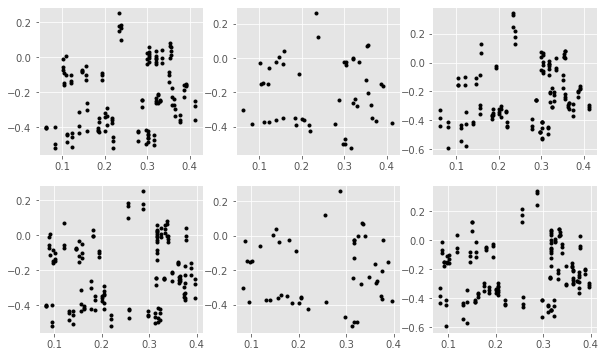

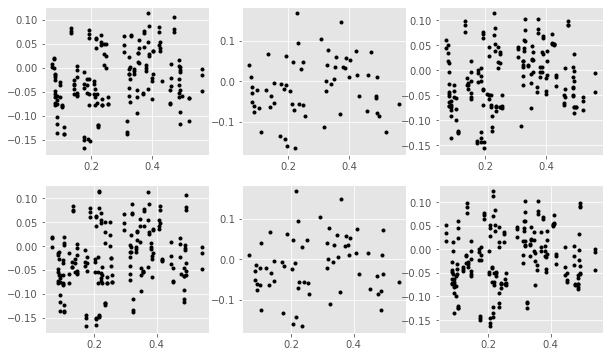

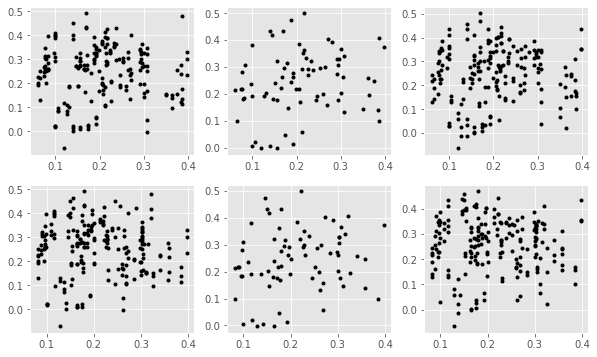

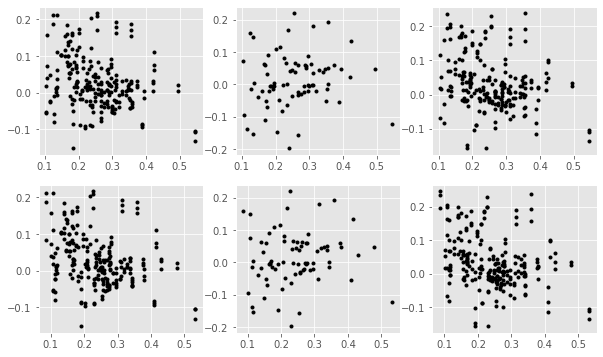

In [39]:
usewb = (-3,3)

dt = df.loc[(df.stimfirst) &
            (df.wb>=usewb[0]) &
            (df.wb<=usewb[1])]

aggdict = {}
for m in channelsFT:
    aggdict[m] = 'mean'
for m in channelsEMG:
    aggdict[m+'_fsphase'] = 'first'

dt = dt.groupby(['date','pulse','wb']).aggregate(aggdict).reset_index()

plt.style.use('ggplot')
datecols = cmx.get_cmap('inferno')(np.linspace(0,1,len(runDates)))
ax = []
for j,d in enumerate(runDates):
    fig, axes = plt.subplots(2, 3, figsize=(10,6))
    ax.append(axes)
    for i,m in enumerate(['RDLM','LDLM']):
        dtt = dt.loc[(dt[m+'_fsphase']!=0) & (dt.date==d)]
        for name, g in dtt.groupby(['date','pulse']):
            if len(g.loc[g.wb==0])!=0:
                xval = g.loc[g.wb==0, m+'_fsphase']
                ax[j][i,0].plot(np.repeat(xval, len(g.loc[g.wb<0])), g.loc[g.wb<0, 'mx'], 'k.')
                ax[j][i,1].plot(np.repeat(xval, len(g.loc[g.wb==0])), g.loc[g.wb==0, 'mx'], 'k.')
                ax[j][i,2].plot(np.repeat(xval, len(g.loc[g.wb>0])), g.loc[g.wb>0, 'mx'], 'k.')
        # ax[i,0].plot(dtt.loc[dtt.wb<0, m+'_fsphase'], dtt.loc[dtt.wb<0, 'mx'], '.', color=datecols[j])
        # ax[i,1].plot(dtt.loc[dtt.wb==0, m+'_fsphase'], dtt.loc[dtt.wb==0, 'mx'], '.', color=datecols[j])
        # ax[i,2].plot(dtt.loc[dtt.wb>0, m+'_fsphase'], dtt.loc[dtt.wb>0, 'mx'], '.', color=datecols[j])

# Estimating "actual pitch" from pitch torque


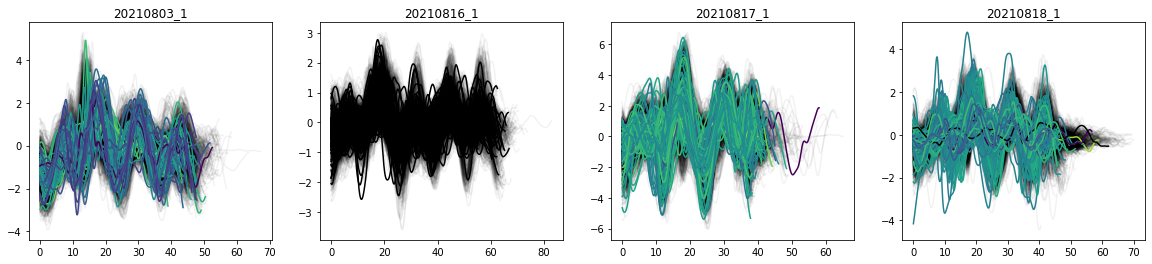

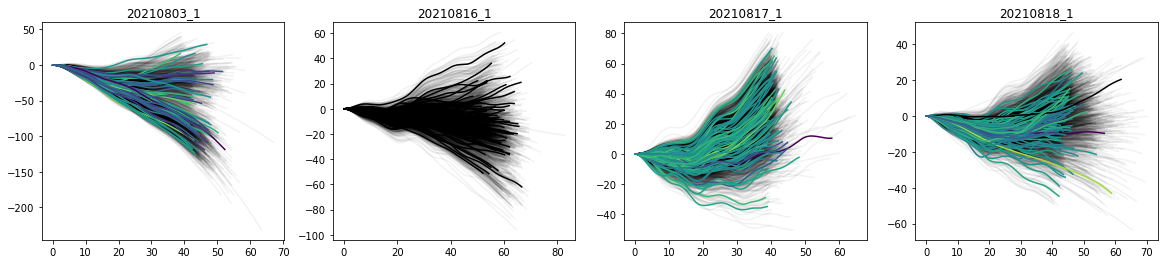

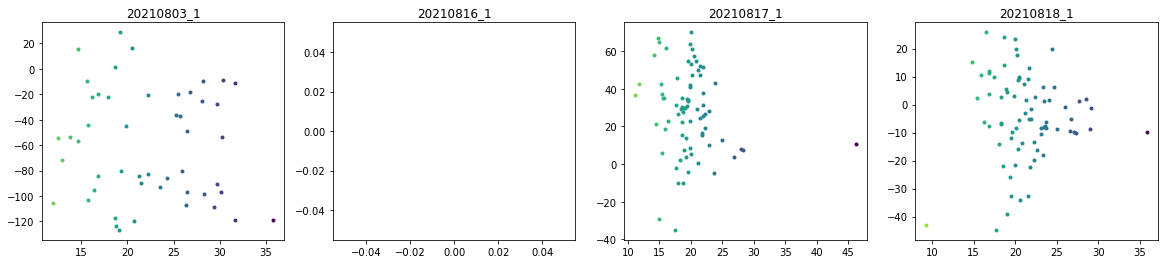

In [6]:
Iyy = 266.7*1e-09 # gmm^2 to kg m^2

figMoment, axMoment = plt.subplots(1, len(runDates), figsize=(20,4))
figTheta, axTheta = plt.subplots(1, len(runDates), figsize=(20,4))
figft, axft = plt.subplots(1, len(runDates), figsize=(20,4))
viridis = cmx.get_cmap('viridis')
mincol, maxcol = 5, 36

for i, (dname, dg) in enumerate(df.loc[df.stimfirst].groupby('date')):
    for name, g in dg.groupby(['pulse','wb']):
        tvec = 1000*(g.Time - g.Time.iloc[0])
        # if len(g.loc[g['LDVM_st'], 'Time'])!=0:
        # tvec = 1000*(g.Time - g.loc[g['LDVM_st'], 'Time'].iloc[0])
        theta = cumtrapz(cumtrapz(g.mx/1000/Iyy, dx=1/fsamp), dx=1/fsamp)*180/np.pi
        thiswbstate = g.wbstate.iloc[0]
        if thiswbstate=='stim':
            yvar = g['tdl'].iloc[0]
            colvar = (maxcol - yvar)/(maxcol - mincol)
            axTheta[i].plot(tvec[:-2], theta, color=viridis(colvar), alpha=1, zorder=1)
            axMoment[i].plot(tvec, g.mx, color=viridis(colvar), alpha=1, zorder=1)
            axft[i].plot(yvar, theta[-1], '.', color=viridis(colvar))
        else:
            axTheta[i].plot(tvec[:-2], theta, color='black', alpha=0.05, zorder=0)
            axMoment[i].plot(tvec, g.mx, color='black', alpha=0.05, zorder=0)
    axTheta[i].set_title(dname)
    axMoment[i].set_title(dname)
    axft[i].set_title(dname)

# Phase-aligned vs. spike-aligned torque waveforms

Inspired by figure 2 of Simon's 2015 PLS paper; compare waveform alignment when aligned by wingbeat phase (zero crossing of hilbert transform) vs when aligned by first spike timing of a given muscle

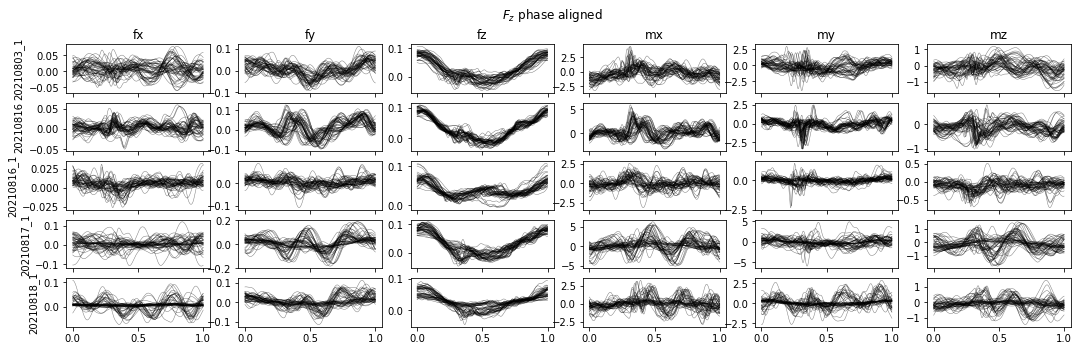

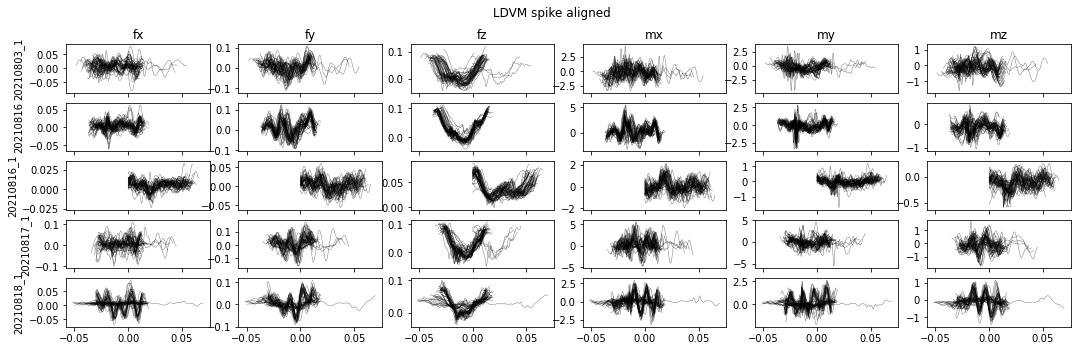

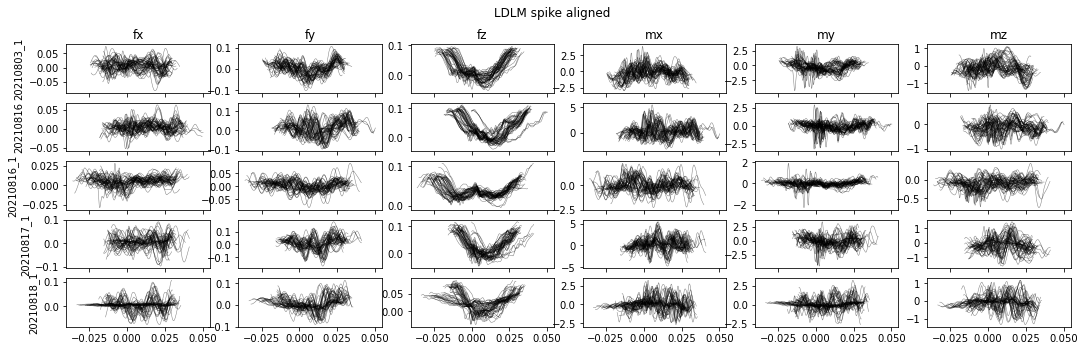

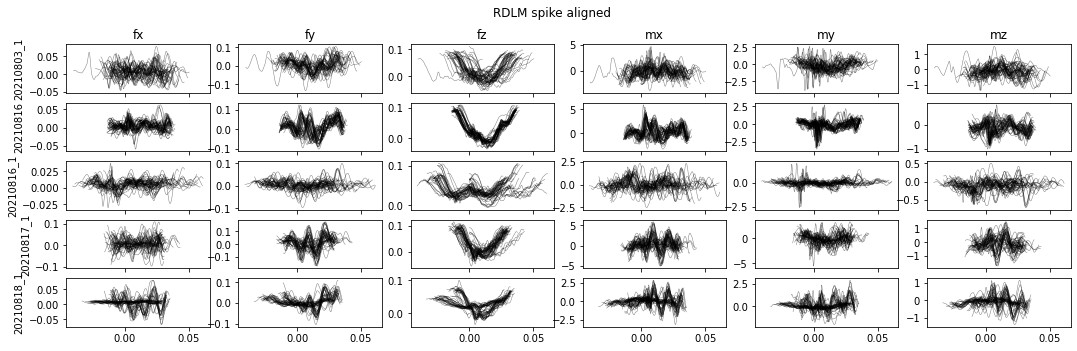

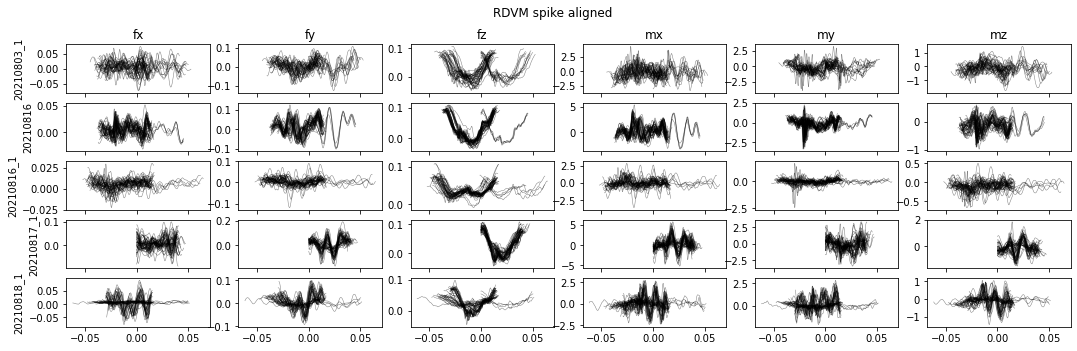

In [14]:
nwb = 50 # How many wingbeats to sample
fsize = (18, 5.2)

#--- Fz phase aligned
fig, ax = plt.subplots(len(runDates), len(channelsFT), figsize=fsize, sharex=True)
for i,d in enumerate(runDates):
    # grab this date
    dt = df.loc[(df.date==d) & (df.wb<-1),].copy()
    # Index the groups, select random subset
    g = dt.groupby(['pulse','wb'])
    a = np.arange(g.ngroups)
    np.random.shuffle(a)
    dt = dt[g.ngroup().isin(a[:nwb])]
    # Loop over randomly chosen groups and plotting variables, and plot
    for name, group in dt.groupby(['pulse','wb']):
        for j,m in enumerate(channelsFT):
            ax[i,j].plot(group.phase, group[m],
                         lw=0.5, alpha=0.5, color='black')
fig.suptitle(r'$F_z$ phase aligned')
for i,m in enumerate(channelsFT):
    ax[0,i].set_title(m)
for i,d in enumerate(runDates):
    ax[i,0].set_ylabel(d)

#--- First spike aligned
for alignMuscle in channelsEMG:
    fig, ax = plt.subplots(len(runDates), len(channelsFT), figsize=fsize, sharex=True)
    for i,d in enumerate(runDates):
        # Grab data
        dt = df.loc[(df.date==d) & (df.wb<-1) & (~np.isnan(df[alignMuscle+'_fs']))].copy()
        # Continue only if aligning muscle had data 
        if len(dt)!=0:
            # Index the groups, select random subset
            g = dt.groupby(['pulse','wb'])
            a = np.arange(g.ngroups)
            np.random.shuffle(a)
            dt = dt[g.ngroup().isin(a[:nwb])]
            # Loop over randomly chosen groups and plotting variables, and plot
            for name, group in dt.groupby(['pulse','wb']):
                for j,m in enumerate(channelsFT):
                    ax[i,j].plot(group.Time-group.Time.iloc[int(group[alignMuscle+'_fs'].iloc[0])],
                                group[m],
                                lw=0.5, alpha=0.5, color='black')
    fig.suptitle(alignMuscle+' spike aligned')
    for i,m in enumerate(channelsFT):
        ax[0,i].set_title(m)
    for i,d in enumerate(runDates):
        ax[i,0].set_ylabel(d)


# Mean waveforms sorted by $\Delta t$ decile
General method for taking a start point (spike triggered, stim triggered, wingbeat, etc), a separating variable (like mean torque, or induced spike time difference), and plotting mean torque traces over time, binned by decile of separating variable

processing and plotting 20210803_1
processing and plotting 20210816_1
processing and plotting 20210817_1
processing and plotting 20210818_1
processing and plotting 20210819


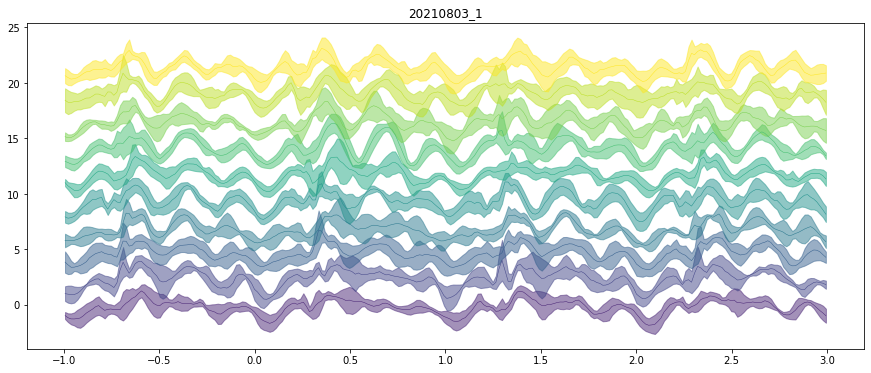

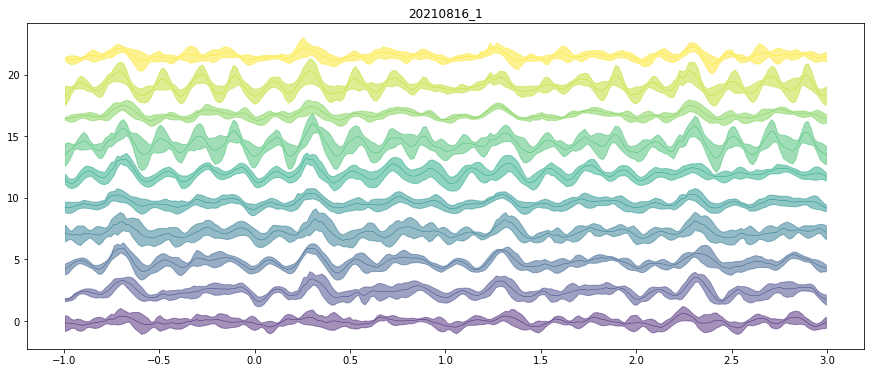

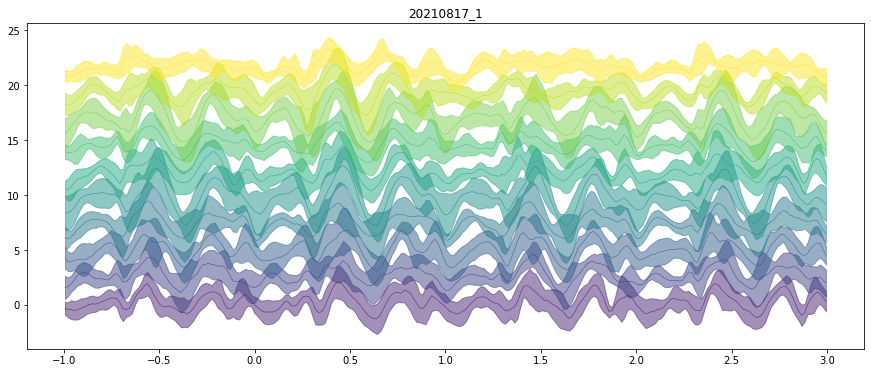

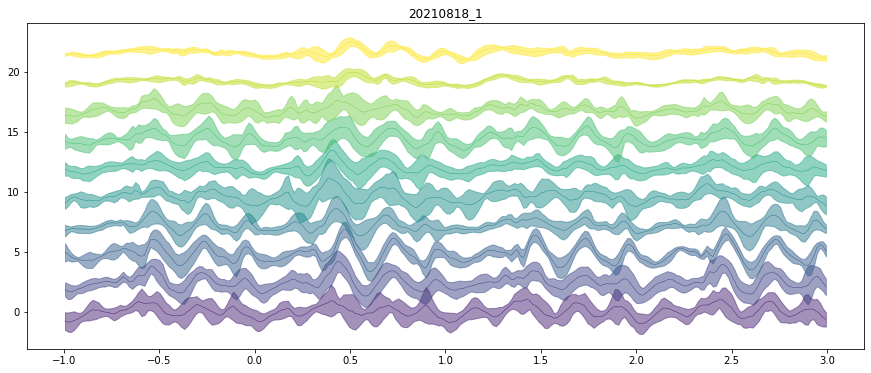

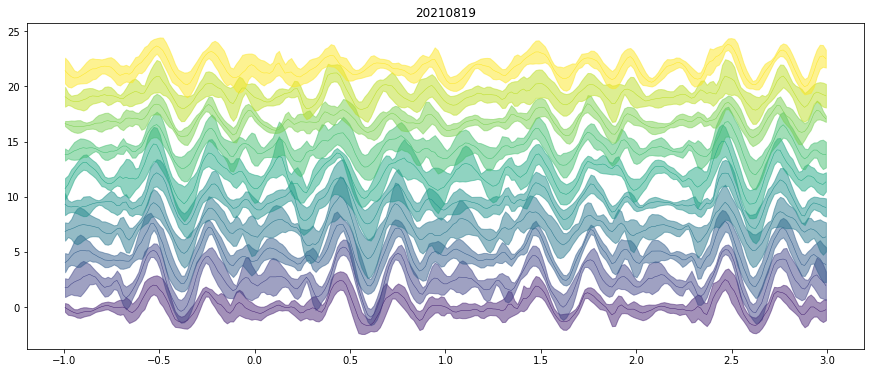

In [3]:
usewb = (-1, 3) # ignore all wingbeat except in this range
ngridx = 250
sep = 2.4 # amount to separate mean traces by 

viridis = cmx.get_cmap('viridis')
# Loop over dates
for di,d in enumerate(runDates):
    print('processing and plotting '+d)
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimfirst)].copy()
                # (df.stimphase<0.5)].copy()
    # Zero time, trim data to region around t=0, change phase to be unique for each wb
    dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
        lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0])
        # lambda g: g['Time'] - (g.loc[(g.wb==-1), 'Time'].iloc[0] + g.loc[g.wb==-1,'LDVM_fs'].iloc[0]/fsamp))
    dt.phase = dt.phase + dt.wb
    # Generate y axis vector
    dt['yvar'] = 0
    dt['td'] = np.where(np.isnan(dt['tdl']), dt['tdr'], dt['tdl'])
    dt['yvar'] = dt.groupby(['date','pulse'], group_keys=False).apply(
        lambda g: g.yvar + (g.loc[g.wbstate=='stim', 'td'].iloc[0] - g.loc[g.wb==-1, 'td'].iloc[0]))
        # lambda g: g.yvar + g.loc[g.wbstate=='stim', 'td'].iloc[0])
        # lambda g: g.yvar + (g.loc[g.wbstate=='stim', 'LDVM_fs'].iloc[0] - g.loc[g.wbstate=='stim', 'LDLM_fs'].iloc[0])/len(g.loc[g.wbstate=='stim']))
    dt = dt.loc[~np.isnan(dt.yvar)]
    # Split by deciles
    dec = np.percentile(dt.yvar, np.arange(0, 100, 10))
    dt['dec'] = np.digitize(dt.yvar, dec)
    # Get mean waveforms for each decile
    xl,yl,gl = binPlot(dt, 'phase', ['mx'], 'dec', 'dec', ngridx+1, makeplot=False)
    # xl,yl,gl = binPlot(dt, 'Time', ['mx'], 'dec', 'dec', ngridx+1, makeplot=False)
    
    # Waveform plots
    plt.figure(figsize=(15,6))
    for i in range(len(xl)):
        plt.fill_between(xl[i]['mean'],
                         sep*i + yl[i]['mean'] - yl[i]['std'],
                         sep*i + yl[i]['mean'] + yl[i]['std'],
                         color=viridis(gl[i]/np.max(gl)),
                         alpha=0.5)
        plt.plot(xl[i]['mean'], sep*i + yl[i]['mean'], color=viridis(gl[i]/np.max(gl)), lw=0.5)
    plt.title(d)

# PCA on Deciles

- Treat individual as a column/variable of the data, do a unified approach


processing 20210803_1
processing 20210816_1
processing 20210817_1
processing 20210818_1
processing 20210819


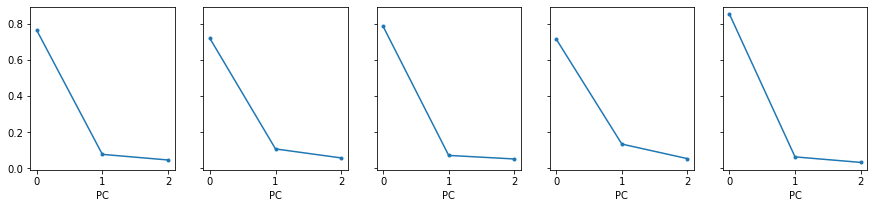

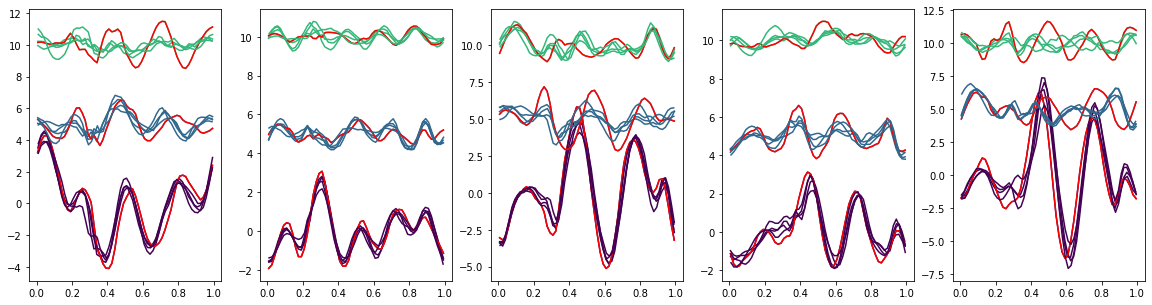

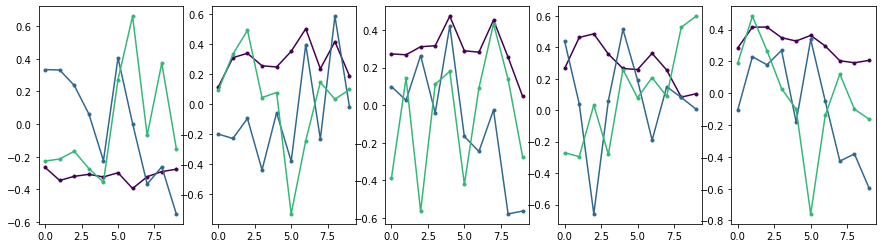

In [8]:
usewb = (-2, 3) # ignore all wingbeat except in this range
usewindow = (-200, 200) # ms, window to actually observe around zero'd time
ncomp = 3
ngridx = 300

figev, axev = plt.subplots(1, len(runDates), figsize=(15,3), sharey=True) # explained variance figure
figpc, axpc = plt.subplots(1, len(runDates), figsize=(20,5)) # Main PC traces
figload, axload = plt.subplots(1, len(runDates), figsize=(15,4)) # PC loadings
viridis = cmx.get_cmap('viridis')

# Loop over dates
for di,d in enumerate(runDates):
    print('processing ' + d)
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimfirst)].copy()
    # Zero time, trim data to region around t=0, change phase to be unique for each wb
    dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
        lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0])
        # lambda g: g['Time'] - (g.loc[(g.wb==-1), 'Time'].iloc[0] + g.loc[g.wb==-1,'LDVM_fs'].iloc[0]/fsamp))
    dt = dt.loc[(dt.Time>=usewindow[0]/1000) & (dt.Time<=usewindow[1]/1000)]
    dt.phase = dt.phase + dt.wb
    # Generate y axis vector
    dt['yvar'] = 0
    dt['td'] = np.where(np.isnan(dt['tdl']), dt['tdr'], dt['tdl'])
    dt['yvar'] = dt.groupby(['date','pulse'], group_keys=False).apply(
        lambda g: g.yvar + (g.loc[g.wbstate=='stim', 'td'].iloc[0] - g.loc[g.wb==-1, 'td'].iloc[0]))
        # lambda g: g.yvar + g.loc[g.wbstate=='stim', 'td'].iloc[0])
        # lambda g: g.yvar + (g.loc[g.wbstate=='stim', 'LDVM_fs'].iloc[0] - g.loc[g.wbstate=='stim', 'LDLM_fs'].iloc[0])/len(g.loc[g.wbstate=='stim']))
    dt = dt.loc[~np.isnan(dt.yvar)]
    
    # Split by deciles
    dec = np.percentile(dt.yvar, np.arange(0, 100, 10))
    dt['dec'] = np.digitize(dt.yvar, dec)
    # Get mean waveforms for each decile
    xl,yl,gl = binPlot(dt, 'phase', ['mx'], 'dec', 'dec', ngridx+1, makeplot=False)
    
    # Put into PCA matrix
    mat = np.vstack([yl[i]['mean'] for i in range(len(yl))]).T
    # Run PCA
    pca = PCA(n_components=ncomp)
    pc = pca.fit_transform(mat)
    
    # Plot PCA explained variance
    axev[di].plot(pca.explained_variance_ratio_, '.-')
    axev[di].set_xlabel('PC')
    # Plot main PC's
    # for i in range(ncomp):
    #     axpc[di].plot(xl[i]['mean'], pc[:,i]+i*5, color=viridis(i/pc.shape[1]))
    for i in range(ncomp):
        for j in np.arange(usewb[0],usewb[1]):
            inds = (xl[i]['mean']<(j+1)) & (xl[i]['mean']>j)
            axpc[di].plot(xl[i]['mean'][inds]-j, pc[inds,i]+i*5, color=viridis(i/pc.shape[1]))
            if j==0:
                axpc[di].plot(xl[i]['mean'][inds]-j, pc[inds,i]+i*5, color='red')
    # Plot loadings of each PC against decile
    for i in range(ncomp):
        axload[di].plot(np.arange(len(xl)), pca.components_[i,:], '.-', color=viridis(i/ncomp))

# CCA Data Setup

In [4]:
phaseOrTime = 'phase'
usewb = (-1,1)
phaseSamples = 300 # total samples to interpolate for phase
timeWindow = (0,500) # samples (before t=0, after t=0)

# make dataframe subset
dt = df.loc[(df.date!='20210816') & 
            (df.wb>=usewb[0]) & 
            (df.wb<usewb[1]) & 
            (df.stimfirst)].copy()
# Zero time, trim data to region around t=0, change phase to be unique for each wb
dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
    lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0])
    # lambda g: g['Time'] - (g.loc[(g.wb==-1), 'Time'].iloc[0] + g.loc[g.wb==-1,'LDVM_fs'].iloc[0]/fsamp))
# Generate stimulation variable vector
dt['yvar'] = 0
dt['td'] = np.where(np.isnan(dt['tdl']), dt['tdr'], dt['tdl'])
dt['yvar'] = dt.groupby(['date','pulse'], group_keys=False).apply(
    lambda g: g.yvar + (g.loc[g.wbstate=='stim', 'td'].iloc[0] - g.loc[g.wb==-1, 'td'].iloc[0]))
    # lambda g: g.yvar + g.loc[g.wbstate=='stim', 'td'].iloc[0])
# Filtering
dt = dt.loc[~np.isnan(dt.yvar)] # bad stim variable
dt.phase = dt.wb + dt.phase # set phase to continuously increase
# Remove any pulses that lack the full wingbeat range
if phaseOrTime=='phase':
    dt = dt.groupby(['date','pulse']).filter(lambda g: (g.wb.iloc[0]==usewb[0]) & (g.wb.iloc[-1]==usewb[1]-1))
# TODO: Write the time version

dt = dt.loc[dt.wb>-1]
usewb = (0,usewb[1])

# Create grouped df
dtgroup = dt.groupby(['date','pulse'])
# Prep by getting dimensions of matrices (how many observations)
n = len(dtgroup.groups.keys())

# Generate X
if phaseOrTime=='Time': # Use Time as X, pass a simple window
    X = np.zeros((n,sum(timeWindow)))
    for i, (name, g) in enumerate(dtgroup):
        index0 = (g.Time==0).idxmax()
        X[i,:] = g.loc[(index0-timeWindow[0]):(index0+timeWindow[1]), 'mx']
else: # Use phase as X, forced to interpolate
    X = np.zeros((n,phaseSamples))
    xInterpAt = np.linspace(usewb[0], usewb[1], phaseSamples)
    for i, (name, g) in enumerate(dtgroup):
        interpfunc = interp1d(g.phase, g['mx'], kind='linear')
        X[i,:] = interpfunc(xInterpAt)
# Generate Y
def aggfunc(g):
    x = [
        # np.mean(g.loc[g.wb==0,'mx'])
        # g.loc[g.wb==-1,'td'].iloc[0],
        g.loc[g.wb==0,'td'].iloc[0]
        # g.yvar.iloc[0]
        # fsamp/len(g.loc[g.wb==-1])
        # g.loc[g.wb==0,'stimphase'].iloc[0]
        ]
    return x
Y = np.vstack(dtgroup.apply(aggfunc).reset_index()[0].to_numpy())

dateRows = np.ravel(dtgroup.aggregate({'date':'first'}).to_numpy())
# deltatd = np.ravel(np.vstack(dtgroup.apply(lambda g: g.loc[g.wb==0,'td'].iloc[0] - g.loc[g.wb==-1,'td'].iloc[0]).reset_index()[0].to_numpy()))
deltatd = np.ravel(np.vstack(dtgroup.apply(lambda g: g.yvar.iloc[0]).reset_index()[0].to_numpy()))

# CCA 

Text(0.5, 0, 'Decile of $t_{DVM}-t_{DLM}$')

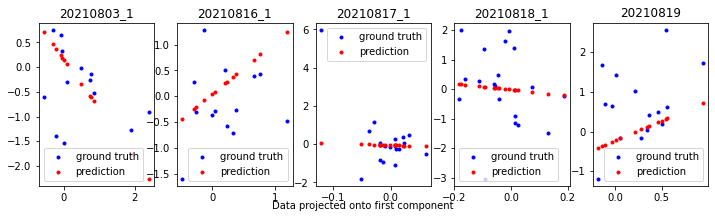

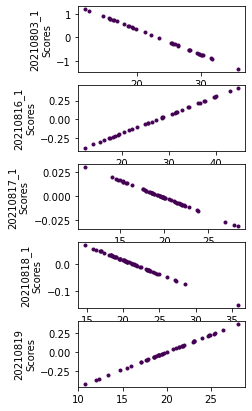

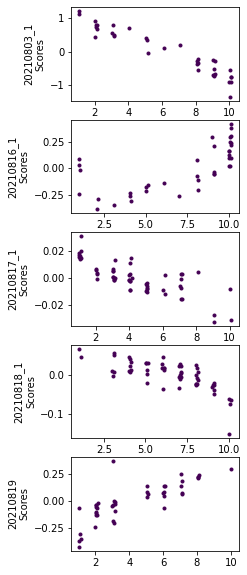

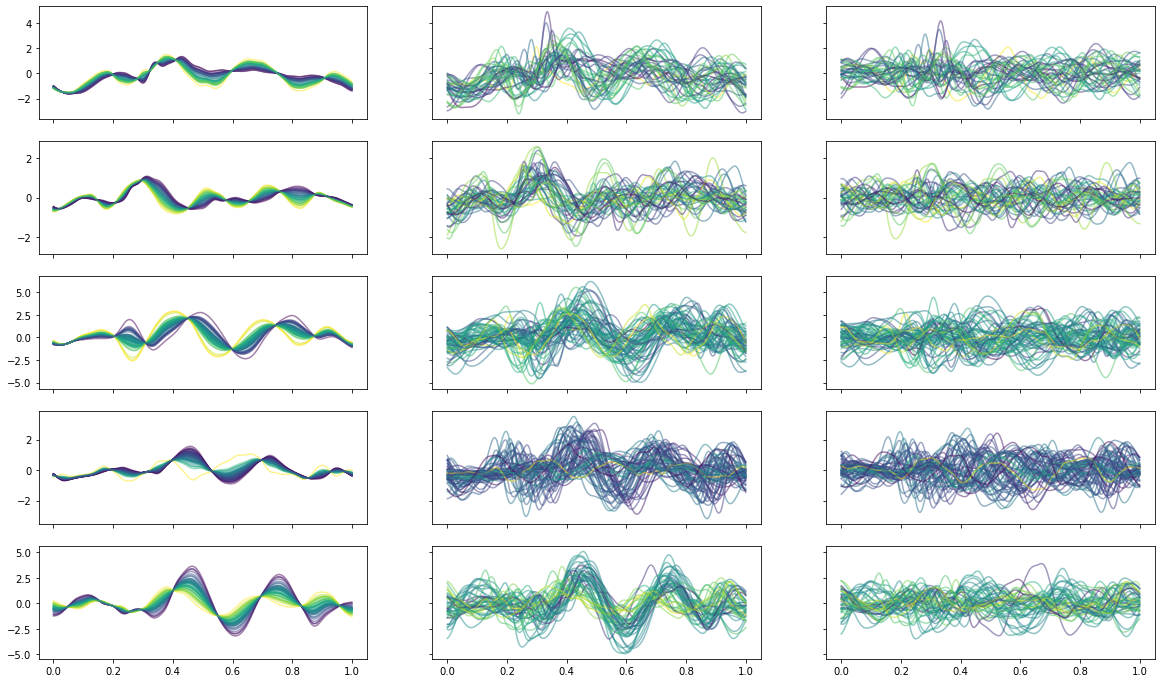

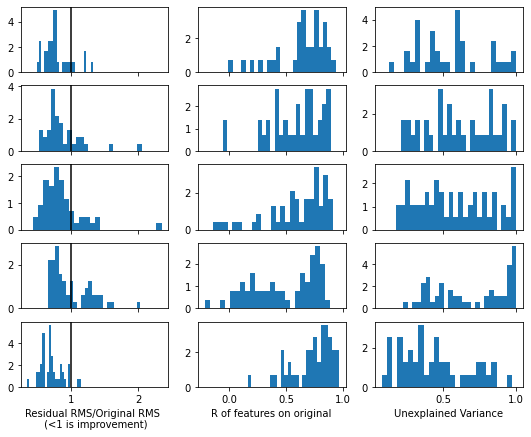

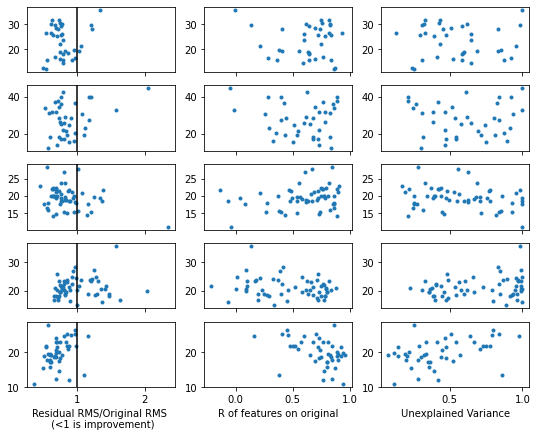

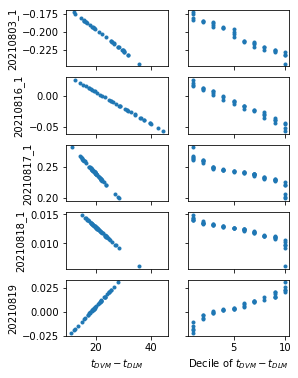

In [5]:
nsamples, ncomp = Y.shape
sep = 1.5
rng = np.random.RandomState(0)

viridis = cmx.get_cmap('viridis')
figtraintest, axtraintest = plt.subplots(1, len(runDates), figsize=(12,3)) # train-test validation
figScore, axScore = plt.subplots(len(runDates), ncomp, figsize=(3*ncomp,7)) # feature scores against each variable
figScoreDec, axScoreDec = plt.subplots(len(runDates), ncomp, figsize=(3*ncomp,10)) # feature scores against deciles of stim variable
figFeat, axFeat = plt.subplots(len(runDates), 3, figsize=(20,12), sharex=True, sharey='row') # recreate waveforms with features
figVar, axVar = plt.subplots(len(runDates), 3, figsize=(9,7), sharex='col')
figVarVsTvar, axVarVsTvar = plt.subplots(len(runDates), 3, figsize=(9,7), sharex='col')
figMean, axMean = plt.subplots(len(runDates), 2, figsize=(4,6), sharex='col', sharey='row')

allcca = []
# Loop over dates
for di, d in enumerate(runDates):
    # Get values for this individual
    thisX, thisY = X[dateRows==d,:], Y[dateRows==d,:]
    # Normalize X and Y
    xmeans, ymeans = np.mean(thisX, axis=0), np.mean(thisY, axis=0)
    xstd, ystd = thisX.std(), thisY.std(axis=0, ddof=1) 
    thisX = (thisX - xmeans)/xstd
    thisY = (thisY - ymeans)/ystd
    
    # Train and test split
    indices = np.arange(len(thisY))
    Xtrain, Xtest, Ytrain, Ytest, itrain, itest = train_test_split(thisX, thisY, indices, random_state=rng)
    # Xtrain, Xtest, Ytrain, Ytest = thisX, thisX, thisY, thisY
    # Deciles of stim timing
    decbins = np.percentile(deltatd, np.arange(0, 100, 10))
    dec = np.digitize(deltatd[dateRows==d], decbins)
    
    # Fit CCA!
    cca = CCA(n_components=ncomp, scale=False)
    cca.fit(Xtrain, Ytrain)
    allcca.append(cca)
    
    # Transform X and Y back (_t is in normalized space, otherwise in regular units space)
    Xtrain_t, Xtest_t, Ytrain_t, Ytest_t = Xtrain, Xtest, Ytrain, Ytest
    Xtrain = Xtrain * xstd + xmeans
    Xtest = Xtest * xstd + xmeans
    Ytrain = Ytrain * ystd + ymeans
    Ytest = Ytest * ystd + ymeans
    
    #--- PLOTS
    # Cross-validate with train/test split
    axtraintest[di].plot(cca.transform(Xtest_t)[:,0], Ytest_t[:,0], 'b.', label='ground truth')
    axtraintest[di].plot(cca.transform(Xtest_t)[:,0], cca.predict(Xtest_t)[:,0], 'r.', label='prediction')
    axtraintest[di].set_title(d)
    axtraintest[di].legend()
    # Plot x scores for each output variable against values of that variable
    for i in range(cca.n_components):
        axScore[di].plot(Ytrain[:,i], cca.transform(Xtrain_t)[:,i], '.', color=viridis(i/ncomp))
    # X scores against decile of stim timing
    for i in range(cca.n_components):
        axScoreDec[di].plot(dec[itrain] + 0.15*np.random.rand(len(itrain)),
                              cca.transform(Xtrain_t)[:,i],
                              '.', color=viridis(i/cca.n_components))
    axScore[di].set_ylabel(d + "\n""Scores")
    axScoreDec[di].set_ylabel(d + "\n""Scores")
    # Plot scored features, original waveforms, and error between the two
    xscores = cca.transform(Xtrain_t)
    feats = (xscores @ cca.x_loadings_.T) * xstd + xmeans
    wave_orig = Xtrain
    wave_resid = wave_orig - feats
    # mincol, maxcol = np.min(xscores), np.max(xscores) # color by score
    mincol, maxcol = np.min(Ytrain), np.max(Ytrain) #color by timing variable
    for i in range(Xtrain.shape[0]):
        # thiscol = viridis((xscores[i]-mincol)/(maxcol-mincol)) # color by score
        thiscol = viridis((Ytrain[i]-mincol)/(maxcol-mincol)) # color by timing variable
        axFeat[di,0].plot(xInterpAt, feats[i,:], color=thiscol, alpha=0.5)
        axFeat[di,1].plot(xInterpAt, wave_orig[i,:], color=thiscol, alpha=0.5)
        axFeat[di,2].plot(xInterpAt, wave_resid[i,:], color=thiscol, alpha=0.5)
    
    # How well features describe original waveforms (correlation) or (RMS residual / RMS of original waveform)
    RMS = np.sqrt(np.mean(wave_resid**2, axis=1)) / np.sqrt(np.mean(wave_orig**2,axis=1))
    corr = np.hstack([np.corrcoef(wave_orig,feats)[i,feats.shape[0]+i] for i in range(feats.shape[0])])
    unexplained_var = 1 - corr**2
    axVar[di,0].hist(RMS, bins=25, density=True)
    axVar[di,1].hist(corr, bins=25, density=True)
    axVar[di,2].hist(unexplained_var, bins=25, density=True)
    axVar[di,0].axvline(1, color='black')
    # How well features describe against timing variable of interest (decile or not)
    axVarVsTvar[di,0].plot(RMS, Ytrain, '.')
    axVarVsTvar[di,1].plot(corr, Ytrain, '.')
    axVarVsTvar[di,2].plot(unexplained_var, Ytrain, '.')
    axVarVsTvar[di,0].axvline(1, color='black')
    
    
    Ydecs = np.digitize(Ytrain, np.percentile(Ytrain, np.arange(0,100,10)))
    axMean[di,0].plot(Ytrain, np.mean(feats,axis=1), '.')
    axMean[di,1].plot(Ydecs, np.mean(feats,axis=1), '.')
    axMean[di,0].set_ylabel(d)
    
# Labels
figtraintest.text(0.5, 0.02, 'Data projected onto first component', ha='center')
metricNames = ['Residual RMS/Original RMS \n (<1 is improvement)', 'R of features on original', 'Unexplained Variance']
for i in range(3):
    axVar[len(runDates)-1,i].set_xlabel(metricNames[i])
    axVarVsTvar[len(runDates)-1,i].set_xlabel(metricNames[i])

# figMean.text(0.01, 0.5, 'Mean Pitch Torque (Nmm)', va='center', rotation='vertical')
axMean[len(runDates)-1,0].set_xlabel(r'$t_{DVM}-t_{DLM}$')
axMean[len(runDates)-1,1].set_xlabel(r'Decile of $t_{DVM}-t_{DLM}$')


Note that feature means scale exactly linearly with timing variable because the only thing varying in features from observation to observation is the _scores_, which we already know vary directly linearly with timing variable. X mean and std transform are applied evenly across all, so don't alter the means, even though they do introduce the phase shift

# Deviation from mean wingbeat

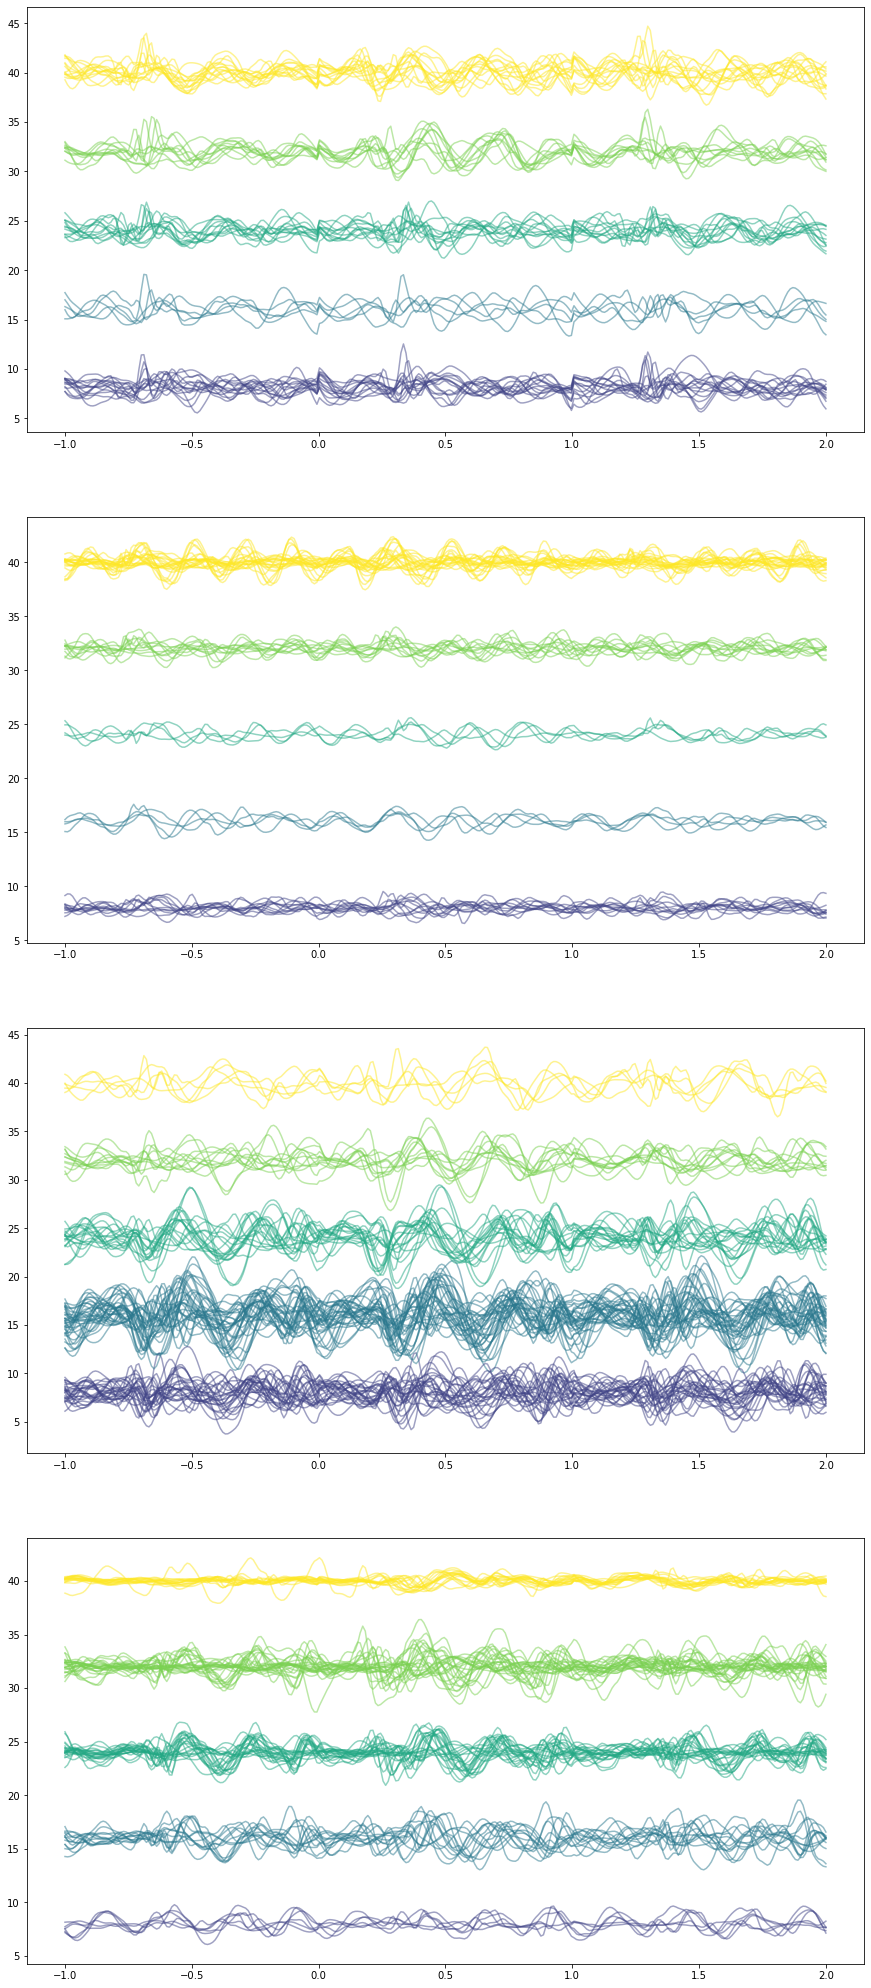

In [13]:
from loess import loess_1d
usewb = (-1,2)
meanwb = (-2,0)
wbsamples = 100
phaseSamples = wbsamples*(usewb[1]-usewb[0])
sep = 8

# make dataframe subset
dt = df.loc[(df.date!='20210816') & 
            (df.wb>=usewb[0]) & 
            (df.wb<usewb[1]) & 
            (df.stimphase<0.5)].copy()
# Zero time, trim data to region around t=0, change phase to be unique for each wb
dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
    lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0])
    # lambda g: g['Time'] - (g.loc[(g.wb==-1), 'Time'].iloc[0] + g.loc[g.wb==-1,'LDVM_fs'].iloc[0]/fsamp))
# Generate stimulation variable vector
dt['yvar'] = 0
dt['td'] = np.where(np.isnan(dt['tdl']), dt['tdr'], dt['tdl'])
dt['yvar'] = dt.groupby(['date','pulse'], group_keys=False).apply(
    lambda g: g.yvar + (g.loc[g.wbstate=='stim', 'td'].iloc[0] - g.loc[g.wb==-1, 'td'].iloc[0]))
    # lambda g: g.yvar + g.loc[g.wbstate=='stim', 'td'].iloc[0])
# Filtering
dt = dt.loc[~np.isnan(dt.yvar)] # bad stim variable
dt['oldphase'] = dt.phase
dt.phase = dt.wb + dt.phase # set phase to continuously increase
# Remove any pulses that lack the full wingbeat range
dt = dt.groupby(['date','pulse']).filter(lambda g: (g.wb.iloc[0]==usewb[0]) & (g.wb.iloc[-1]==usewb[1]-1))

# Create grouped df
dtgroup = dt.groupby(['date','pulse'])
# Get dimensions of matrices (how many observations)
n = len(dtgroup.groups.keys())
# Get a few key variables (which rows are which date, delta tDVM-tDLM for each row, etc.)
rowDates = np.ravel(dtgroup.aggregate({'date':'first'}).to_numpy())
deltatd = np.ravel(np.vstack(dtgroup.apply(lambda g: g.loc[g.wb==0,'td'].iloc[0] - g.loc[g.wb==-1,'td'].iloc[0]).reset_index()[0].to_numpy()))

def loessfunc(g):
    _,ynew,_ = loess_1d.loess_1d(g.oldphase.to_numpy(), g.mx.to_numpy(), np.linspace(0,1,wbsamples), degree=1, frac=0.3)
    return ynew
# Create mean waveform
dtwave = dt.loc[(dt.wb>=meanwb[0]) & (dt.wb<=meanwb[1])]
meanwave = dtwave.groupby('date').apply(
    # lambda g: interp1d(g.oldphase, g.mx, kind='linear')(np.linspace(0,1,wbsamples)))
    lambda g: loessfunc(g))

# Interpolate waveforms from all data
interpAt = np.linspace(usewb[0], usewb[1], phaseSamples)
X = np.zeros((n,phaseSamples))
for i, (name, g) in enumerate(dt.loc[(dt.wb>=usewb[0])&(dt.wb<=usewb[1])].groupby(['date','pulse'])):
    X[i,:] = interp1d(g.phase, g['mx'], kind='linear')(interpAt)
# Difference each wingbeat from mean wingbeat
Xreg = X.copy()
for i in range(n):
    for j in range(usewb[1]-usewb[0]):
        X[i,wbsamples*j:(j+1)*wbsamples] -= meanwave[runDates.index(rowDates[i])]

#--- Plot
viridis = cmx.get_cmap('viridis')
fig, ax = plt.subplots(len(runDates), 1, figsize=(15,36))
# Loop over dates
for di, d in enumerate(runDates):
    inds = rowDates==d
    # Deciles of stim timing
    decbins = np.percentile(deltatd, np.arange(0, 100, 20))
    # for i in range(10):
    #     ax[di].plot(interpAt, sep*(i+1) + np.tile(meanwave[di],usewb[1]-usewb[0]), 'k', linewidth=0.5)
    # Loop over pulses
    for i in np.where(inds)[0]:
        thisbin = np.digitize(deltatd[i], decbins)
        ax[di].plot(interpAt, sep*thisbin + X[i,:], alpha=0.5, color=viridis(thisbin/5))



# Waveforms sorted by $\Delta t$: No binning/means

Text(0.5, 1.0, '$\\Delta (t_{DVM}-t_{DLM})$')

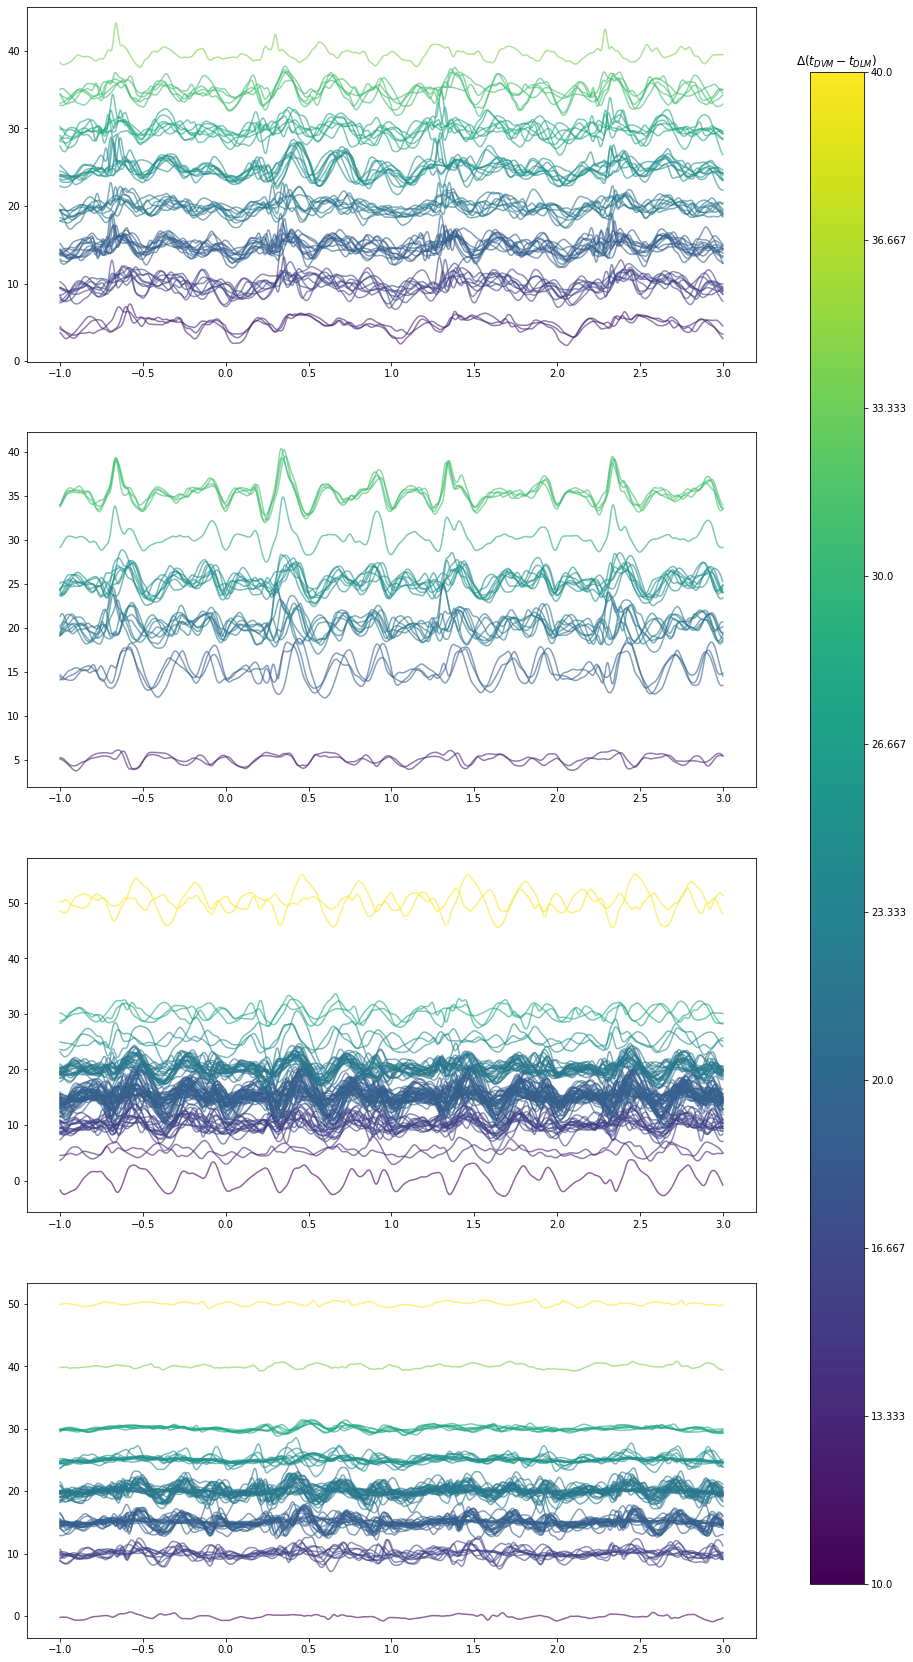

In [222]:
usewb = (-1, 3) # ignore all wingbeat except in this range
nbin = 10
# bins = np.linspace(-3, 16, nbin)
bins = np.linspace(10, 40, nbin)

fig, ax = plt.subplots(len(runDates), 1, figsize=(15,30))
viridis = cmx.get_cmap('viridis')

# Loop over dates
for di,d in enumerate(runDates):
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimphase<0.5)].copy()
    # Zero time, trim data to region around t=0
    dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
        # lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0])
        lambda g: g['Time'] - (g.loc[(g.wb==-1), 'Time'].iloc[0] + g.loc[g.wb==-1,'LDVM_fs'].iloc[0]/fsamp))
    # Preallocate/prepare for loop
    grouped_df = dt.groupby(['date','pulse'])
    ngroup, groupsize = grouped_df.ngroups, np.max(grouped_df.size())
    vals = []
    # Loop over each pulse, add to matrix
    for name, g in grouped_df:
        # thiscol = g.loc[g.wbstate=='stim', 'tdl'].iloc[0] - g.loc[g.wb==-1, 'tdl'].iloc[0]
        thiscol = g.loc[g.wbstate=='stim', 'tdl'].iloc[0]
        # thiscol = (g.loc[g.wbstate=='stim', 'LDVM_fs'].iloc[0] - g.loc[g.wbstate=='stim', 'LDLM_fs'].iloc[0])/len(g.loc[g.wbstate=='stim'])
        vals.append(thiscol)
        thisbin = np.digitize(thiscol, bins)
        ax[di].plot(g.phase+g.wb, g.mx+5*thisbin, color=viridis(thisbin/nbin), alpha=0.6)
        # ax[di].plot(g.Time, g.mx+5*thisbin, color=viridis(thisbin/nbin), alpha=0.6)
# Colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
mincol, maxcol = bins[0], bins[-1]
cbar = fig.colorbar(cmx.ScalarMappable(norm=None, cmap=viridis),
                    ticks=(bins-mincol)/(maxcol-mincol),
                    cax=cbar_ax)
cbar.ax.set_yticklabels([str(round(x,3)) for x in bins])
cbar.ax.set_title(r'$\Delta (t_{DVM}-t_{DLM})$')

# Spike-Triggered Mean Pitch

20210803_1
20210816_1
20210817_1
20210818_1


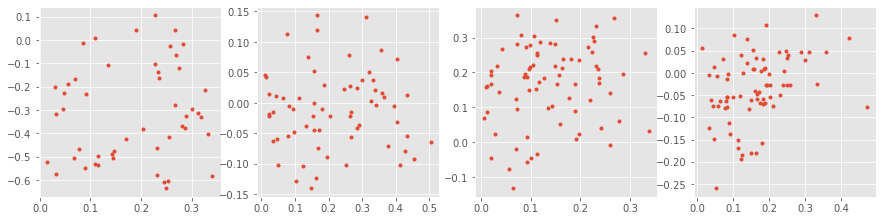

In [44]:
window = 500 #samples

fig, ax = plt.subplots(1, len(runDates), figsize=(15,3.5))
# Loop over dates
for di,d in enumerate(runDates):
    print(d)
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimfirst)].copy()
    # Zero time, trim data to region around t=0, change phase to be unique for each wb
    dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
        lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0])
        # lambda g: g['Time'] - (g.loc[(g.wb==-1), 'Time'].iloc[0] + g.loc[g.wb==-1,'LDVM_fs'].iloc[0]/fsamp))
    # Generate y axis vector
    dt['yvar'] = 0
    dt['yvar'] = dt.groupby(['date','pulse'], group_keys=False).apply(
        lambda g: g.yvar + g.stimphase)
        # lambda g: g.yvar + (g.loc[g.wbstate=='stim', 'tdl'].iloc[0] - g.loc[g.wb==-1, 'tdl'].iloc[0]))
        # lambda g: g.yvar + g.loc[g.wbstate=='stim', 'tdl'].iloc[0])
        # lambda g: g.yvar + (g.loc[g.wbstate=='stim', 'LDVM_fs'].iloc[0] - g.loc[g.wbstate=='stim', 'LDLM_fs'].iloc[0])/len(g.loc[g.wbstate=='stim']))
    dt = dt.loc[~np.isnan(dt.yvar)]
    
    # make dataframe subset
    dt = dt.loc[dt.Time>=0]
    dt = dt.groupby(['date','pulse']).aggregate({
        'mx' : lambda g: np.mean(g.iloc[0:window]),
        'yvar' : 'first'
    })
    
    ax[di].plot(dt.yvar, dt.mx, '.')


# $(t_{DVM}-t_{DLM})$ vs stimphase:
How well does the actual stimulus phase connect to DVM-DLM timing difference? Not important, but just curious

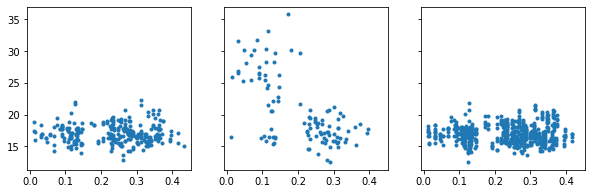

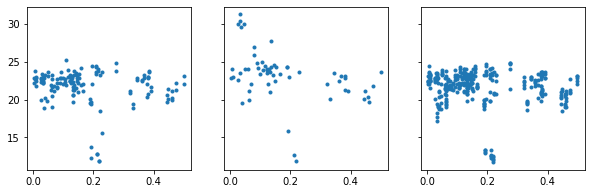

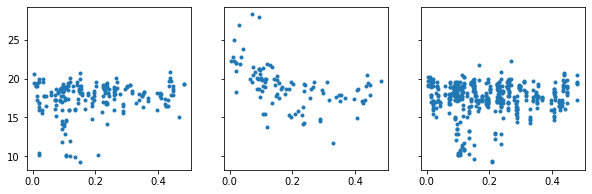

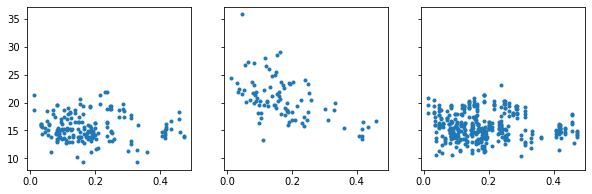

In [163]:
ncomp = 4
usewb = (-2, 6)

aggdict = {}
aggdict['wbstate'] = 'first'
aggdict['stimphase'] = 'first'
aggdict['tdl'] = 'first'
aggdict['tdr'] = 'first'

# Loop over dates
for d in runDates:
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimphase<0.5)].copy()
    
    g = dt.groupby(['date','pulse','wb']).aggregate(aggdict)
    
    fig, ax = plt.subplots(1, 3, figsize=(10,3), sharex=True, sharey=True)
    for i,state in enumerate(['pre','stim','post']):
        dsub = g.loc[g.wbstate==state]
        ax[i].plot(dsub.stimphase, dsub.tdl, '.')

# How wingbeat period/frequency ($F_z$ cycles) is impacted by stimulation

Text(0.5, 1.0, '$\\Delta (t_{DVM}-t_{DLM})$')

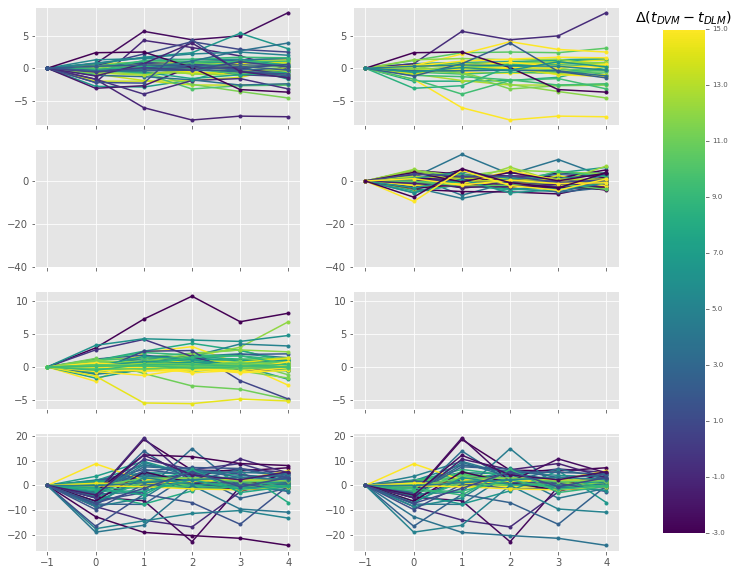

In [13]:
plt.close('all')
usewb = (-1, 5) # ignore all wingbeat except in this range
fig, ax  = plt.subplots(len(runDates), 2, sharex=True, figsize=(12,10))
# Loop over dates
for ind,d in enumerate(runDates):
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimfirst)].copy()
    # Color setup
    viridis = cmx.get_cmap('viridis')
    maxcol, mincol = 15, -3
    # Zero time
    dt.Time = dt.groupby(['date','pulse'], group_keys=False).apply(
        lambda g: g['Time'] - g.loc[(g.wb==0), 'Time'].iloc[0])
    # Preallocate/prepare for loop
    grouped_df = dt.groupby(['date','pulse'])
    ngroup, groupsize = grouped_df.ngroups, np.max(grouped_df.size())
    # Loop over each pulse, add to matrix
    for name, g in dt.groupby(['date','pulse']):
        # Loop over left and right
        for lri,lr in enumerate(['l','r']):
            thiscol = g.loc[g.wbstate=='stim', 'td'+lr].iloc[0] - g.loc[g.wb==-1, 'td'+lr].iloc[0]
            # thiscol = g.loc[g.wbstate=='stim', 'tdr'].iloc[0]
            # thiscol = (g.loc[g.wbstate=='stim', 'LDVM_fs'].iloc[0] - g.loc[g.wbstate=='stim', 'LDLM_fs'].iloc[0])/len(g.loc[g.wbstate=='stim'])
            dg = g.groupby('wb').size()
            ax[ind,lri].plot(dg.index, (dg.values-dg.values[0])/10, '.-',
                                color=viridis((maxcol-thiscol)/(maxcol-mincol)))
# Labels
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
tickrange = np.linspace(mincol, maxcol, 10)
cbar = fig.colorbar(cmx.ScalarMappable(norm=None, cmap=viridis),
                    ticks=(tickrange-mincol)/(maxcol-mincol),
                    cax=cbar_ax)
cbar.ax.set_yticklabels([str(round(x,3)) for x in tickrange], fontsize=7)
cbar.ax.set_title(r'$\Delta (t_{DVM}-t_{DLM})$')

# How DLM-DVM timing changes after stimulation

/var/folders/wk/44b_fwgs06q9gfdjtfs124640000gp/T/ipykernel_85469/3355697949.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axd[len(runDates)-1].set_xticklabels(


[Text(-4.0, 0, '-4--3'),
 Text(-3.0, 0, '-3--2'),
 Text(-2.0, 0, '-2--1'),
 Text(-1.0, 0, '-1-0'),
 Text(0.0, 0, '0-1'),
 Text(1.0, 0, '1-2'),
 Text(2.0, 0, '2-3'),
 Text(3.0, 0, '3-4'),
 Text(4.0, 0, '4-5')]

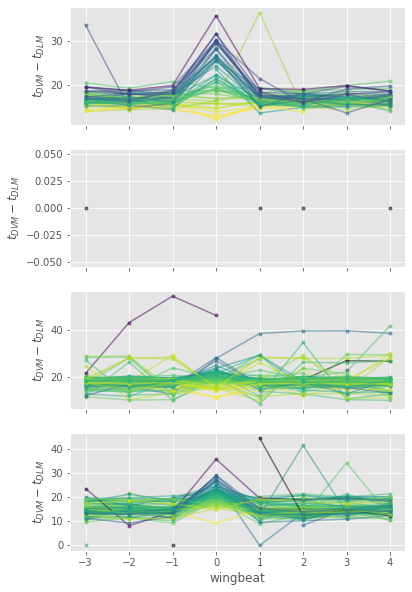

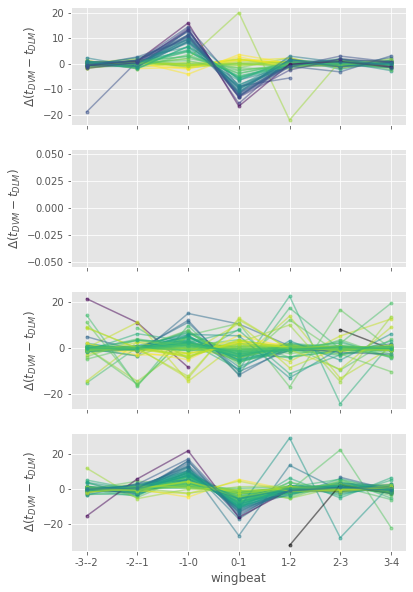

In [12]:
usewb = (-3, 5) # ignore all wingbeat except in this range
viridis = cmx.get_cmap('viridis')
maxcol, mincol = 36, 13
fig, ax  = plt.subplots(len(runDates), 1, sharex=True, figsize=(6,10))
figd, axd  = plt.subplots(len(runDates), 1, sharex=True, figsize=(6,10))
# Loop over dates
for ind,d in enumerate(runDates):
    # make dataframe subset
    dt = df.loc[(df.date==d) & 
                (df.wb>=usewb[0]) & 
                (df.wb<usewb[1]) & 
                (df.stimfirst)].copy()
    # Loop over each pulse, add to matrix
    for name, g in dt.groupby(['date','pulse']):
        thiscol = g.loc[g.wbstate=='stim', 'tdl'].iloc[0]
        dg = g.groupby('wb').aggregate({'wb' : 'first',
                                        'tdl' : 'first'})
        ax[ind].plot(dg.wb, dg.tdl, '.-',
                     color=viridis((maxcol-thiscol)/(maxcol-mincol)),
                     alpha=0.5)
        axd[ind].plot(dg.wb.to_numpy()[:-1], np.diff(dg.tdl), '.-',
                      color=viridis((maxcol-thiscol)/(maxcol-mincol)),
                      alpha=0.5)
    ax[ind].set_ylabel(r'$t_{DVM}-t_{DLM}$')
    axd[ind].set_ylabel(r'$\Delta (t_{DVM}-t_{DLM})$')
# Labels
ax[len(runDates)-1].set_xlabel('wingbeat')
axd[len(runDates)-1].set_xlabel('wingbeat')
axd[len(runDates)-1].set_xticklabels(
    labels=[str(x)+'-'+str(x+1) for x in np.arange(usewb[0]-1,usewb[1])])


To illustrate what's going on in weird trials let's pick a few really odd ones:

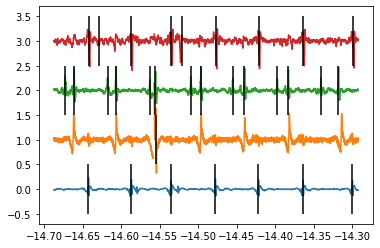

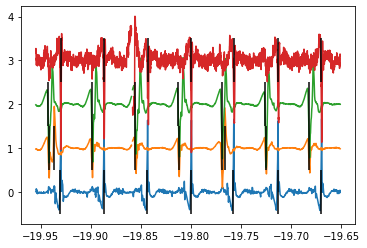

In [42]:
# Really high delta t:
dt = df.loc[
    (df.wb>=usewb[0]) & 
    (df.wb<usewb[1]) & 
    (df.stimphase<0.5) & 
    (df.date=='20210803_1') &
    (df.pulse==19)].copy()
plt.figure()
for i,m in enumerate(channelsEMG):
    plt.plot(dt.Time, dt[m]+i)
    plt.vlines(x=dt.loc[dt[m+'_st'], 'Time'], ymin=i-0.5, ymax=i+0.5, color='black', zorder=3)
# Really low delta t:
dt = df.loc[
    (df.wb>=usewb[0]) & 
    (df.wb<usewb[1]) & 
    (df.stimphase<0.5) & 
    (df.date=='20210816') &
    (df.pulse==26)].copy()
plt.figure()
for i,m in enumerate(channelsEMG):
    plt.plot(dt.Time, dt[m]+i)
    plt.vlines(x=dt.loc[dt[m+'_st'], 'Time'], ymin=i-0.5, ymax=i+0.5, color='black', zorder=3)